In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os, random, shutil
import PIL  
from pathlib import Path
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Переименование файлов

In [ ]:
def func_rename_photos(data_folder):
    for folder in os.listdir(data_folder):
        for i, photo in enumerate(os.listdir(data_folder + '//' + folder)):
            os.rename(f'{data_folder}//{folder}//{photo}', f'{data_folder}//{folder}//photo_{i}.jpg')

In [3]:
func_rename_photos('data')

## Разделение датасета

In [ ]:
# Функция для разделения на тренировочную и валидационную выборки
def split_data(source_root, target_root):
    '''
    source_root - где находится датасет
    target_root - в какой папке хранить разделенный датасет 
    '''
    source_root = Path(source_root)
    target_root = Path(target_root)
    train_size = 0.8

    for class_name in os.listdir(source_root):
        files = os.listdir(source_root / class_name)
        random.shuffle(files)
        split = int(len(files) * train_size)

        for subset, subset_files in (('train', files[:split]), ('val', files[split:])):
            dct = target_root / subset / class_name
            dct.mkdir(parents=True, exist_ok=True)
            for f in subset_files:
                shutil.copy(source_root / class_name / f, dct / f)

In [5]:
split_data('data', 'data_split')

In [ ]:
# Функция для подсчета файлов
def total_files(dct):
    total = 0

    for root, dir, file in os.walk(dct):
        total += len(file)

    return total

In [7]:
print(f'Кол-во файлов в train: {total_files("data_split/train")}')
print(f'Кол-во файлов в val: {total_files("data_split/val")}')

Кол-во файлов в train: 546
Кол-во файлов в val: 139


In [ ]:
# Дублирование изображение (oversampling)
# def duplicate_files(src_dir, dst_dir, class_name, factor):
#     src = os.path.join(src_dir, class_name)
#     dst = os.path.join(dst_dir, class_name)
#     os.makedirs(dst, exist_ok=True)

#     files = [f for f in os.listdir(src) if f.lower().endswith(('.jpg','.png'))]
#     for f in files:
#         shutil.copy(os.path.join(src, f), os.path.join(dst, f))

#     target_count = len(files) * factor
#     while len(os.listdir(dst)) < target_count:
#         f = random.choice(files)
#         new_name = f"{len(os.listdir(dst))}_{f}"
#         shutil.copy(os.path.join(src, f), os.path.join(dst, new_name))

In [ ]:
# for df in ['train', 'val']:
#     duplicate_files(f'data_split/{df}', f'data_split_oversampled/{df}', 'good', factor=1)    
#     duplicate_files(f'data_split/{df}', f'data_split_oversampled/{df}', 'bad', factor=2)
#     duplicate_files(f'data_split/{df}', f'data_split_oversampled/{df}', 'great', factor=2)
#     duplicate_files(f'data_split/{df}', f'data_split_oversampled/{df}', 'not_bad', factor=2)

In [ ]:
# print(f'Кол-во файлов в train: {total_files("data_split_oversampled/train")}')
# print(f'Кол-во файлов в val: {total_files("data_split_oversampled/val")}')

Кол-во файлов в train: 514
Кол-во файлов в val: 134


## Предобработка данных

In [ ]:
# функция применения clahe для улучшения контрастности и удаление теней
def apply_clahe_pil(img):  
    img = (img * 255).astype('uint8') if img.max() <= 1.0 else img.astype('uint8') # 
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5., tileGridSize=(32,32))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb.astype('float32')

def preprocess_with_clahe(x):
    x_uint8 = (x.astype(np.float32))
    if x_uint8.max() <= 1.0:
        x_uint8 = (x_uint8 * 255).astype('uint8')
    else:
        x_uint8 = x_uint8.astype('uint8')
    rgb = apply_clahe_pil(x_uint8)
    return tf.keras.applications.mobilenet_v3.preprocess_input(rgb)

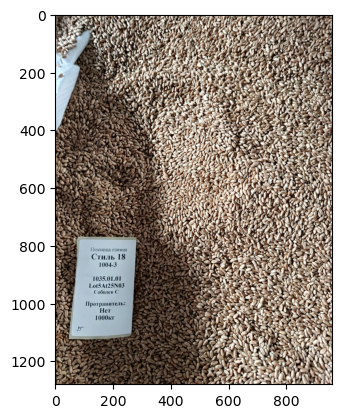

In [3]:
photo_before_clahe = cv2.imread('data_split/train/good/photo_141.jpg')
photo_before_clahe = cv2.cvtColor(photo_before_clahe, cv2.COLOR_BGR2RGB)

plt.imshow(photo_before_clahe)
plt.show()

L-channel mean before: 117.01177788628472
L-channel mean after : 123.993004


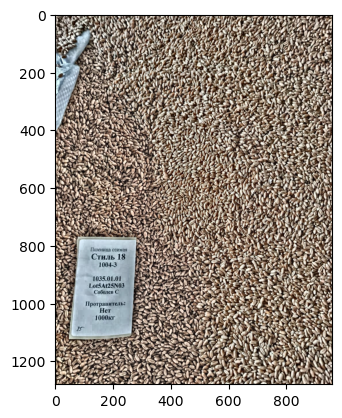

In [4]:
photo_after_clahe = apply_clahe_pil(photo_before_clahe.astype('uint8'))

print("L-channel mean before:", photo_before_clahe.mean())
print("L-channel mean after :", photo_after_clahe.mean())

plt.imshow(photo_after_clahe.astype('uint8'))
plt.show()

In [4]:
def create_seed_mask(img, lower_seed=np.array([0,0,0]), upper_seed=np.array([180,250,250])):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    mask = cv2.inRange(hsv, lower_seed, upper_seed)

    mask = cv2.medianBlur(mask, 5)

    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return mask

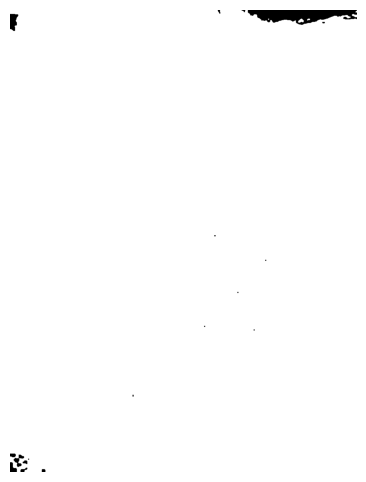

In [6]:
img_path = "data_split/train/good/photo_100.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = create_seed_mask(img)

plt.figure(figsize=(6,6))
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
def preprocess_seed_image(img, target_size=(224,224)):
    mask = create_seed_mask(img)
    mask_uint8 = (mask > 0).astype(np.uint8) * 255

    img_masked = cv2.bitwise_and(img, img, mask=mask_uint8)


    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_gray_rgb = cv2.merge([img_gray, img_gray, img_gray])

    img_clahe = apply_clahe_pil(img_gray_rgb)

    img_resized = cv2.resize(img_clahe, target_size)
    img_preprocessed = tf.keras.applications.mobilenet_v3.preprocess_input(img_resized)

    return img_preprocessed

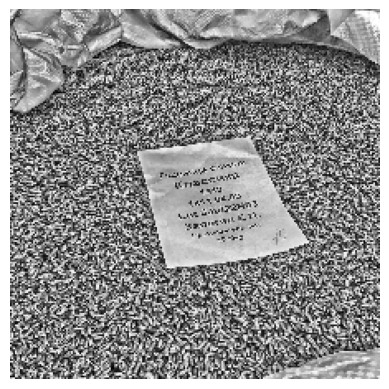

In [8]:
img_path = "data_split/train/good/photo_1.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_preprocessed = preprocess_seed_image(img)

img_display = ((img_preprocessed - img_preprocessed.min()) / 
               (img_preprocessed.max() - img_preprocessed.min()) * 255).astype(np.uint8)

plt.imshow(img_display, cmap='gray') 
plt.axis('off')
plt.show()

In [21]:
import random

def extract_patches(img, patch_size=(224,224), max_patches=5, min_intensity=10):
    h, w, _ = img.shape
    ph, pw = patch_size
    patches = []

    for _ in range(max_patches * 2):
        if h <= ph or w <= pw:
            patch = cv2.resize(img, patch_size)
            patches.append(patch)
            continue

        y = random.randint(0, h - ph)
        x = random.randint(0, w - pw)
        patch = img[y:y+ph, x:x+pw]

        if patch.mean() > min_intensity:
            patches.append(patch)

        if len(patches) >= max_patches:
            break

    return patches


In [32]:
def preprocess_patch_image(img, target_size=(224,224)):
    patches = extract_patches(img, patch_size=target_size, max_patches=1)
    patch = patches[0]  
    
    mask = create_seed_mask(patch)
    mask_uint8 = (mask > 0).astype(np.uint8) * 255
    img_masked = cv2.bitwise_and(patch, patch, mask=mask_uint8)

    img_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY)
    img_gray_rgb = cv2.merge([img_gray, img_gray, img_gray])
    img_clahe = apply_clahe_pil(img_gray_rgb)

    img_preprocessed = tf.keras.applications.mobilenet_v3.preprocess_input(img_clahe)
    return img_preprocessed

In [33]:
def preprocess_patch_bag(img, target_size=(224,224), max_patches=5):
    patches = extract_patches(img, patch_size=target_size, max_patches=max_patches)
    bag = []
    for patch in patches:
        mask = create_seed_mask(patch)
        mask_uint8 = (mask > 0).astype(np.uint8) * 255
        img_masked = cv2.bitwise_and(patch, patch, mask=mask_uint8)

        img_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY)
        img_gray_rgb = cv2.merge([img_gray, img_gray, img_gray])
        img_clahe = apply_clahe_pil(img_gray_rgb)

        img_preprocessed = tf.keras.applications.mobilenet_v3.preprocess_input(img_clahe)
        bag.append(img_preprocessed)

    return np.array(bag)

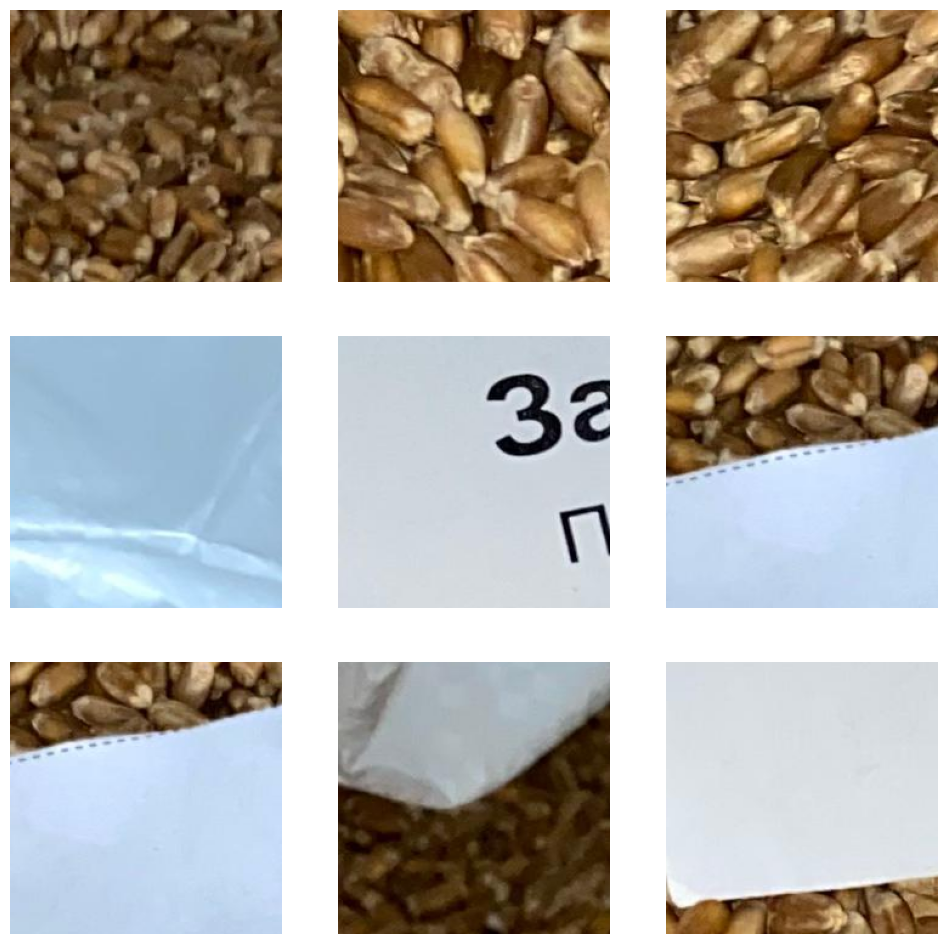

In [31]:
img_path = "data_split/train/bad/photo_0.jpg"
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

patches = extract_patches(img, patch_size=(224,224), max_patches=9)

plt.figure(figsize=(12, 12))
for i, patch in enumerate(patches):
    plt.subplot(3, 3, i+1)
    plt.imshow(patch)
    plt.axis("off")
plt.show()


In [39]:
ordered_classes = ['bad', 'not_bad', 'good', 'great']

def preprocessing_data(train_dir, val_dir, target_size=(224, 224), batch_size=16):
    train_datagen = ImageDataGenerator(
        preprocessing_function=lambda img: preprocess_patch_image(img, target_size=target_size),
        rotation_range=10,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.2,
        brightness_range=(0.6, 1.2),
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(
        preprocessing_function=lambda img: preprocess_patch_image(img, target_size=target_size)
    )

    train_gen = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        classes=ordered_classes
    )

    val_gen = val_datagen.flow_from_directory(
        directory=val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        classes=ordered_classes
    )

    return train_gen, val_gen

In [43]:
train_gen, val_gen = preprocessing_data('data_split/train', 'data_split/val', target_size=(224, 224), batch_size=4)

Found 546 images belonging to 4 classes.
Found 139 images belonging to 4 classes.


In [8]:
labels = train_gen.labels
class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
)

class_weights_dict = dict(enumerate(class_weights))
print('Class weights:', class_weights_dict)

Class weights: {0: 1.128099173553719, 1: 0.853125, 2: 0.6408450704225352, 3: 2.625}


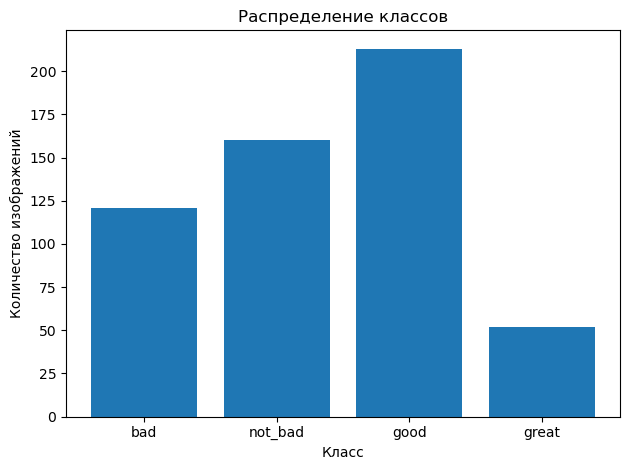

In [10]:
labels = train_gen.classes
class_names = list(train_gen.class_indices.keys())

plt.hist(labels, bins=np.arange(len(class_names)+1)-0.5, rwidth=0.8)
plt.xticks(np.arange(len(class_names)), labels=class_names)
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.title("Распределение классов")
plt.tight_layout()
plt.show()

In [11]:
print(class_names)

['bad', 'not_bad', 'good', 'great']


## Обучение

In [12]:
def ordinal_focal_loss(gamma=2.0, alpha=0.25, k=0.5):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred,
                                  tf.keras.backend.epsilon(),
                                  1. - tf.keras.backend.epsilon())

        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_weight  = alpha * tf.pow(1 - y_pred, gamma)

        true_idx = tf.cast(tf.argmax(y_true, axis=1), tf.float32)
        pred_idx = tf.cast(tf.range(tf.shape(y_pred)[1]), tf.float32)

        dist_matrix = tf.abs(
            tf.expand_dims(true_idx, axis=1) - tf.expand_dims(pred_idx, axis=0)
        )

        weight = focal_weight * (1.0 + k * dist_matrix)

        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss


## Модель с MIL агрегацией

In [ ]:
def mil_generator(generator, target_size=(224,224), max_patches=5):
    while True:
        batch_x, batch_y = next(generator)
        bags = []
        for img in batch_x:
            bag = preprocess_patch_bag(img, target_size=target_size, max_patches=max_patches)
            bags.append(bag)
        max_len = max(len(b) for b in bags)
        bags_padded = np.zeros((len(bags), max_len, target_size[0], target_size[1], 3), dtype=np.float32)
        for i, b in enumerate(bags):
            bags_padded[i, :len(b)] = b
        yield bags_padded, batch_y


In [47]:
train_mil_gen = mil_generator(train_gen, max_patches=2)
val_mil_gen   = mil_generator(val_gen, max_patches=2)

In [44]:
input_shape = (224, 224, 3)

base_model = applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

In [ ]:
input_shape = (None, 224, 224, 3) 
num_classes = len(ordered_classes)

patch_input = keras.Input(shape=(224,224,3))
patch_features = base_model(patch_input, training=False)
patch_features = GlobalAveragePooling2D()(patch_features)
patch_encoder = keras.Model(patch_input, patch_features)

bag_input = keras.Input(shape=(None, 224,224,3))  

encoded_patches = keras.layers.TimeDistributed(patch_encoder)(bag_input)

bag_representation = keras.layers.GlobalAveragePooling1D()(encoded_patches)

x = Dense(1024, activation='relu')(bag_representation)
x = keras.layers.Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = keras.Model(bag_input, output)

model.compile(
    optimizer=Adam(1e-4),
    loss=ordinal_focal_loss(),
    metrics=['accuracy']
)

In [15]:
base_model.trainable = False 
num_classes = len(list(train_gen.class_indices))

inputs = keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=ordinal_focal_loss(),
        metrics=['accuracy']
)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches (InputLayer)        [(None, None, 224, 224,   0         
                              3)]                                
                                                                 
 time_distributed_3 (TimeDi  (None, None, 7, 7, 960)   2996352   
 stributed)                                                      
                                                                 
 tf.math.reduce_mean_3 (TFO  (None, 7, 7, 960)         0         
 pLambda)                                                        
                                                                 
 dense_2 (Dense)             (None, 7, 7, 512)         492032    
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 512)         0         
                                                             

In [48]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('train_log.csv')
]

In [49]:
model.fit(
    train_mil_gen,
    validation_data=val_mil_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    epochs=5,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/5
137/137 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.6484

f:\my_files\works\jupyter\testScripts\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - 309s 2s/step - loss: 0.1070 - accuracy: 0.6484 - val_loss: 0.0597 - val_accuracy: 0.7410 - lr: 1.0000e-04
Epoch 2/5
137/137 [==============================] - 390s 3s/step - loss: 0.0708 - accuracy: 0.7070 - val_loss: 0.0466 - val_accuracy: 0.7122 - lr: 1.0000e-04
Epoch 3/5
137/137 [==============================] - 270s 2s/step - loss: 0.0564 - accuracy: 0.7436 - val_loss: 0.0362 - val_accuracy: 0.7914 - lr: 1.0000e-04
Epoch 4/5
137/137 [==============================] - 258s 2s/step - loss: 0.0465 - accuracy: 0.7894 - val_loss: 0.0404 - val_accuracy: 0.7914 - lr: 1.0000e-04
Epoch 5/5
137/137 [==============================] - 343s 3s/step - loss: 0.0464 - accuracy: 0.7509 - val_loss: 0.0440 - val_accuracy: 0.7698 - lr: 1.0000e-04


In [51]:
base_model.trainable = True
for layer in base_model.layers[:50]:  
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=ordinal_focal_loss(),
              metrics=['accuracy'])

history_fine = model.fit(
    train_mil_gen, 
    epochs=5, 
    validation_data=val_mil_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen), 
    class_weight=class_weights_dict, 
    callbacks=callbacks
    )

Epoch 1/5
137/137 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.8022

f:\my_files\works\jupyter\testScripts\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - 454s 3s/step - loss: 0.0338 - accuracy: 0.8022 - val_loss: 0.0317 - val_accuracy: 0.7986 - lr: 1.0000e-05
Epoch 2/5
137/137 [==============================] - 318s 2s/step - loss: 0.0273 - accuracy: 0.8242 - val_loss: 0.0297 - val_accuracy: 0.8129 - lr: 1.0000e-05
Epoch 3/5
137/137 [==============================] - 241s 2s/step - loss: 0.0277 - accuracy: 0.8168 - val_loss: 0.0302 - val_accuracy: 0.7986 - lr: 1.0000e-05
Epoch 4/5
137/137 [==============================] - 287s 2s/step - loss: 0.0292 - accuracy: 0.8168 - val_loss: 0.0309 - val_accuracy: 0.8201 - lr: 1.0000e-05
Epoch 5/5
137/137 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.8480
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
137/137 [==============================] - 194s 1s/step - loss: 0.0252 - accuracy: 0.8480 - val_loss: 0.0329 - val_accuracy: 0.8201 - lr: 1.0000e-05


## Проверка модели

In [ ]:
def predict_on_patches(model, img, patch_size=(224,224), max_patches=5):
    patches = extract_patches(img, patch_size=patch_size, max_patches=max_patches)

    preprocessed_patches = [preprocess_patch_image(p, target_size=patch_size) for p in patches]
    preprocessed_patches = np.array(preprocessed_patches)

    bag = np.expand_dims(preprocessed_patches, axis=0)

    pred = model.predict(bag, verbose=0)[0]

    return pred

In [66]:
from sklearn.metrics import confusion_matrix, classification_report

pred_model = keras.models.load_model('best_model.h5', custom_objects={'loss': ordinal_focal_loss()})

all_preds = []
all_true = []

for i in range(len(val_gen)):
    batch_x, batch_y = val_gen[i]
    for j in range(len(batch_x)):
        img = batch_x[j]
        label = np.argmax(batch_y[j])

        pred_vector = predict_on_patches(pred_model, img, max_patches=5)

        all_preds.append(np.argmax(pred_vector))
        all_true.append(label)

# отчёт
names = list(val_gen.class_indices.keys())
print(classification_report(all_true, all_preds, target_names=names))
print(confusion_matrix(all_true, all_preds))

              precision    recall  f1-score   support

         bad       1.00      0.97      0.98        31
     not_bad       0.78      0.51      0.62        41
        good       0.72      0.94      0.82        54
       great       1.00      0.85      0.92        13

    accuracy                           0.81       139
   macro avg       0.87      0.82      0.83       139
weighted avg       0.83      0.81      0.80       139

[[30  1  0  0]
 [ 0 21 20  0]
 [ 0  3 51  0]
 [ 0  2  0 11]]


Предсказанный класс: good


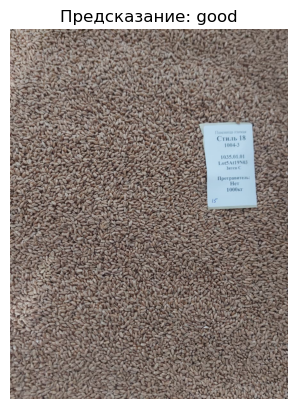

In [73]:
img_path = 'data_split/val/good/photo_105.jpg'

img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224)) 
img_array = keras.preprocessing.image.img_to_array(img) 
img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array) 

pred = predict_on_patches(model, img_array, max_patches=5) 

class_idx = np.argmax(pred)
class_name = list(train_gen.class_indices.keys())[class_idx]

print("Предсказанный класс:", class_name) 
plt.imshow(keras.preprocessing.image.load_img(img_path)) 
plt.title(f"Предсказание: {class_name}")
plt.axis('off') 
plt.show()

In [ ]:
def make_gradcam_heatmap(img_path, model, preprocess_fn=None, class_names=None):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    if preprocess_fn is not None:
        img_array = preprocess_fn(img_array)

    img_array = np.expand_dims(img_array, axis=0)

    base_model = model.get_layer("MobilenetV3large")
    last_conv_layer = base_model.get_layer("last_layet")

    grad_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=[last_conv_layer.output, base_model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds_base = grad_model(img_array, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(conv_outputs)
        x = model.layers[-3](x)  
        x = model.layers[-2](x)  
        preds = model.layers[-1](x)
        class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    img_orig = cv2.imread(img_path)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_orig)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    if class_names:
        label = class_names[class_index.numpy()]
    else:
        label = f"class {class_index.numpy()}"
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM ({label})")
    plt.axis("off")
    plt.show()

    return class_index.numpy(), preds[0].numpy()


In [ ]:
class_names = list(train_gen.class_indices.keys())
make_gradcam_heatmap_mil('data_split/val/not_bad/photo_108.jpg', pred_model, preprocess_fn=preprocess_with_clahe, class_names=class_names)

ValueError: Не найден Conv2D слой в MobileNetV3!

## Тестовая модель

In [87]:
test_data = pd.DataFrame(columns=['path', 'target'])

test_folders = ['goods', 'not_bad']
for i, folder in enumerate(test_folders):
    for j, photo in enumerate(os.listdir(f'data/{folder}')):
        if i > 59:
            break
        test_data.loc[f'{i}_{j}'] = [f'data/{folder}/{photo}', folder]

In [88]:
test_data

,path,target
0_0,data/goods/photo_0.jpg,goods
0_1,data/goods/photo_1.jpg,goods
0_2,data/goods/photo_10.jpg,goods
0_3,data/goods/photo_100.jpg,goods
0_4,data/goods/photo_101.jpg,goods
...,...,...
1_55,data/not_bad/photo_59.jpg,not_bad
1_56,data/not_bad/photo_6.jpg,not_bad
1_57,data/not_bad/photo_7.jpg,not_bad
1_58,data/not_bad/photo_8.jpg,not_bad


In [89]:
test_data['target'] = test_data['target'].astype('category').cat.codes
test_data = tf.data.Dataset.from_tensor_slices((test_data['path'], test_data['target']))

In [90]:
test_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int8, name=None))>

In [91]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img, label

In [92]:
test_data = test_data.map(load_image)

In [93]:
test_data

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int8, name=None))>

In [94]:
total = len(test_data)
val_size = int(0.2 * total)

test_data = test_data.shuffle(buffer_size=total, seed=42)

val_ds = test_data.take(val_size)
train_ds = test_data.skip(val_size)

train_ds = train_ds.batch(8).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(8).prefetch(tf.data.AUTOTUNE)

In [ ]:
model = keras.applications.MobileNetV3Small(weights=None, classes=2, input_shape=(224, 224, 3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=2)

ValueError: Input 0 of layer "expanded_conv/depthwise/pad" is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (None, 32, 112, 112, 16)

In [98]:
model.save("model_saved")
converter = tf.lite.TFLiteConverter.from_saved_model("model_saved")
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)   

INFO:tensorflow:Assets written to: model_saved\assets


INFO:tensorflow:Assets written to: model_saved\assets


In [115]:
img_path = "data/goods/photo_100.jpg"

# Загружаем и готовим точно так же, как при обучении
img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [224, 224])
img = img / 255.0

# Добавляем размерность батча: (1, 224, 224, 3)
img = tf.expand_dims(img, axis=0)

# Предсказание
pred = model.predict(img)          # форма (1, 2), т.к. classes=2
print(pred)

# Класс с максимальной вероятностью
class_idx = np.argmax(pred, axis=1)[0]
print("Предсказанный класс:", class_idx)

1/1 [==============================] - 1s 797ms/step
[[0.5310525  0.46894747]]
Предсказанный класс: 0
